<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [32]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

def create_geometry(geom_type):
    """Generate different pore geometries"""
    outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

    if geom_type == "shifted_disk":
        inclusion = dde.geometry.Disk(center=[0.7, 0.3], radius=0.15)
    elif geom_type == "ellipse":
        inclusion = dde.geometry.Ellipse(center=[0.5, 0.5], a=0.25, b=0.15)
    elif geom_type == "rectangle":
        inclusion = dde.geometry.Rectangle(xmin=[0.4, 0.4], xmax=[0.6, 0.6])
    elif geom_type == "multi_pore":
        inclusion = (
            dde.geometry.Disk(center=[0.3, 0.3], radius=0.1) +
            dde.geometry.Disk(center=[0.7, 0.7], radius=0.1)
        )
    else:  # Default case
        inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)

    return outer - inclusion

def run_simulation(geom_type, iterations=5000):
    """Run complete simulation for given geometry"""
    # 1. Create geometry and boundary condition
    fluid_domain = create_geometry(geom_type)

    # 2. Define boundary conditions
    def boundary_solid(x, on_boundary):
        return on_boundary and fluid_domain.on_boundary(x)

    robin_bc = dde.icbc.RobinBC(
        fluid_domain,
        robin_func,
        on_boundary=boundary_solid
    )

    # 3. Set up PDE and data
    data = dde.data.PDE(
        fluid_domain,
        pde,
        [robin_bc],
        num_domain=1200,
        num_boundary=150,
        num_test=250,
    )

    # 4. Build and train model
    net = dde.nn.FNN([2] + [64] * 5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)
    losshistory, _ = model.train(iterations=iterations, display_every=1000)

    # 5. Save results
    dde.saveplot(
        losshistory,
        train_state=model.train_state,
        issave=True,
        isplot=False,
        output_dir=f"/content/results/{geom_type}"
    )
    return model

# List of geometries to test
geometries = [
    "default",
    "shifted_disk",
    "ellipse",
    "rectangle",
    "multi_pore"
]

# Run trials for all geometries
results = {}
for geom in geometries:
    print(f"\n=== Running simulation for {geom} geometry ===")
    results[geom] = run_simulation(geom)


=== Running simulation for default geometry ===
Compiling model...
Building feed-forward neural network...
'build' took 0.080940 s

'compile' took 0.734062 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.46e-03, 2.39e-02]    [8.43e-03, 2.39e-02]    []  
1000      [5.26e-08, 6.61e-08]    [4.95e-08, 6.61e-08]    []  
2000      [1.66e-08, 6.10e-09]    [1.50e-08, 6.10e-09]    []  
3000      [9.27e-09, 1.17e-09]    [8.10e-09, 1.17e-09]    []  
4000      [1.11e-06, 1.20e-05]    [1.05e-06, 1.20e-05]    []  
5000      [3.29e-09, 1.81e-09]    [2.99e-09, 1.81e-09]    []  

Best model at step 5000:
  train loss: 5.10e-09
  test loss: 4.80e-09
  test metric: []

'train' took 13.192304 s



FileNotFoundError: [Errno 2] No such file or directory: 'results/default'

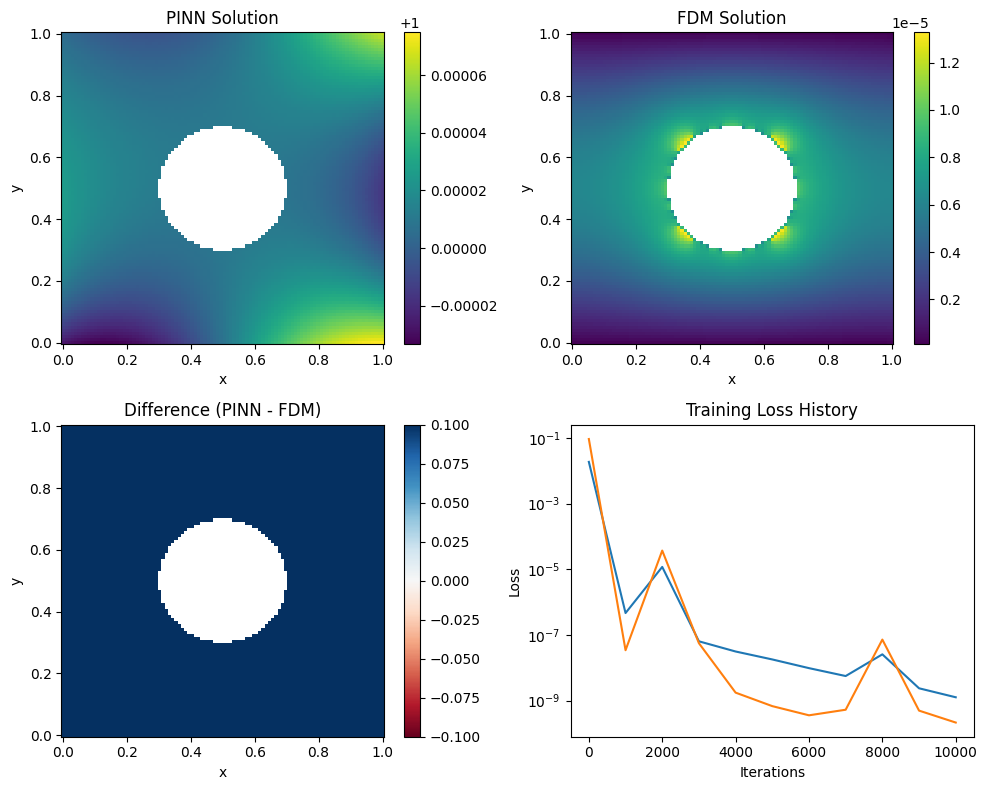

In [11]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))

Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()


Processing default geometry...
Compiling model...
Building feed-forward neural network...
'build' took 0.079248 s

'compile' took 0.756271 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.97e-03, 2.33e-02]    [1.11e-02, 2.33e-02]    []  
1000      [1.12e-05, 2.53e-04]    [1.06e-05, 2.53e-04]    []  
2000      [1.24e-05, 2.46e-04]    [1.17e-05, 2.46e-04]    []  
3000      [1.22e-05, 2.45e-04]    [1.16e-05, 2.45e-04]    []  
4000      [1.24e-05, 2.44e-04]    [1.17e-05, 2.44e-04]    []  
5000      [1.22e-05, 2.44e-04]    [1.16e-05, 2.44e-04]    []  

Best model at step 5000:
  train loss: 2.56e-04
  test loss: 2.56e-04
  test metric: []

'train' took 12.442331 s



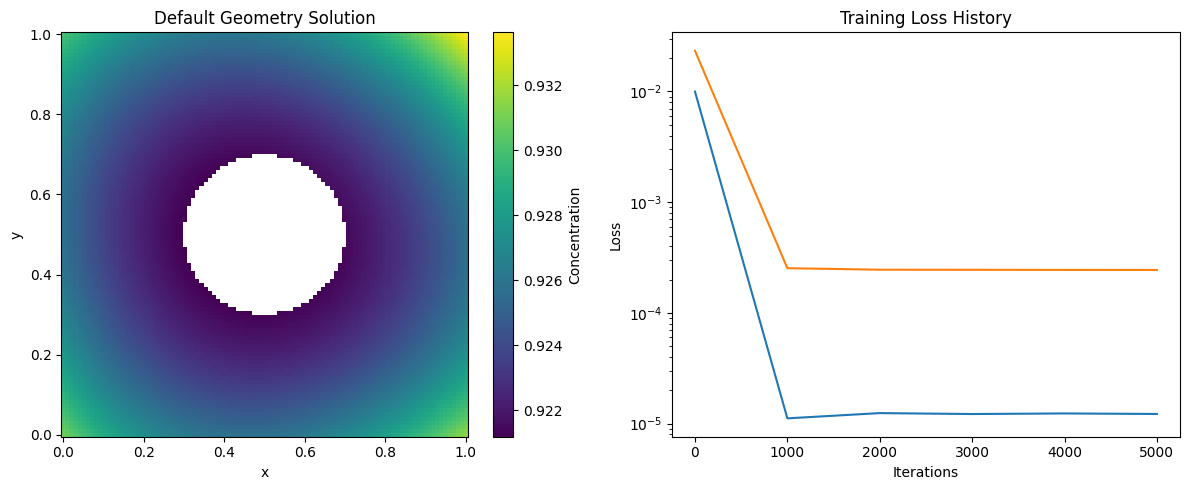


Processing shifted_disk geometry...
Compiling model...
Building feed-forward neural network...
'build' took 0.081493 s

'compile' took 0.798639 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.02e-02, 2.53e-02]    [1.07e-02, 2.53e-02]    []  
1000      [8.67e-06, 2.34e-04]    [6.90e-06, 2.34e-04]    []  
2000      [1.68e-05, 2.29e-04]    [1.65e-05, 2.29e-04]    []  
3000      [7.05e-06, 2.31e-04]    [6.80e-06, 2.31e-04]    []  
4000      [7.16e-06, 2.31e-04]    [7.15e-06, 2.31e-04]    []  
5000      [7.08e-06, 2.31e-04]    [7.09e-06, 2.31e-04]    []  

Best model at step 5000:
  train loss: 2.38e-04
  test loss: 2.38e-04
  test metric: []

'train' took 12.733590 s



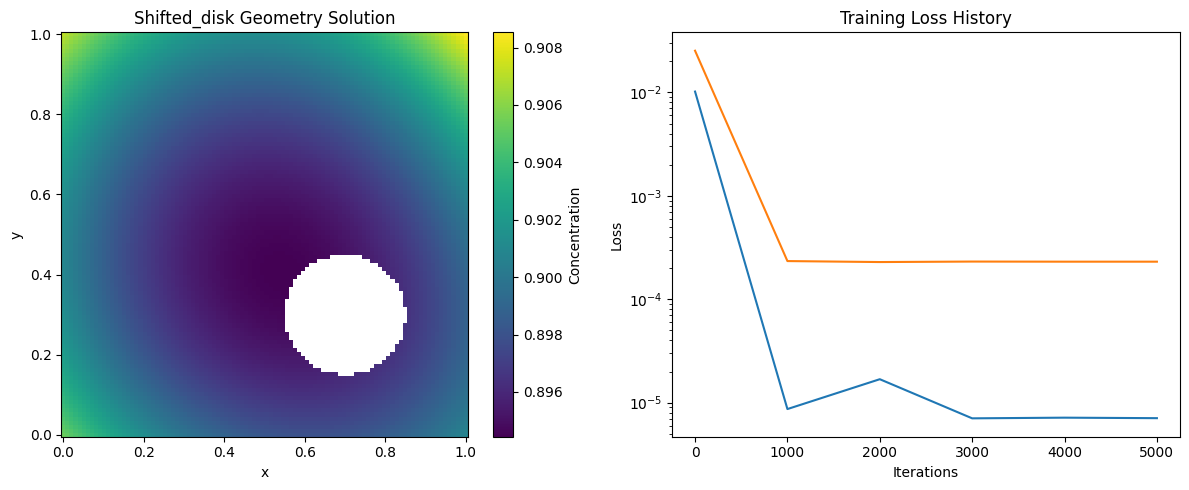


Processing ellipse geometry...
Compiling model...
Building feed-forward neural network...
'build' took 0.084212 s



NotImplementedError: Ellipse.boundary_normal to be implemented

In [45]:
# %% [code]
# 1. Environment setup and imports
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Clear TensorFlow session for Colab stability
tf.keras.backend.clear_session()

# 2. Define physical parameters
D = 1.0    # Diffusion coefficient
k = 0.1    # Reaction rate
alpha = 1.0 # Surface concentration

# 3. Geometry creation function
def create_geometry(geom_type):
    """Create computational domain with different pore shapes"""
    outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

    if geom_type == "shifted_disk":
        inclusion = dde.geometry.Disk([0.7, 0.3], 0.15)
    elif geom_type == "ellipse":
        inclusion = dde.geometry.Ellipse([0.5, 0.5], 0.25, 0.15)
    elif geom_type == "rectangle":
        inclusion = dde.geometry.Rectangle([0.4, 0.4], [0.6, 0.6])
    elif geom_type == "multi_pore":
        inclusion = (
            dde.geometry.Disk([0.3, 0.3], 0.1) +
            dde.geometry.Disk([0.7, 0.7], 0.1)
        )
    else:  # Default circular pore
        inclusion = dde.geometry.Disk([0.5, 0.5], 0.2)

    return outer - inclusion, inclusion

# 4. Define PDE and boundary conditions
def pde(x, y):
    """Steady-state diffusion-reaction equation"""
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return D * (dy_xx + dy_yy) - k * y

robin_func = lambda x, y: (k/D) * (alpha - y)  # Correct Robin BC formulation

# 5. Main simulation function with integrated plotting
def run_simulation(geom_type, iterations=5000):
    """Complete workflow for one geometry"""
    # Create geometry
    fluid_domain, inclusion = create_geometry(geom_type)

    # Define boundary condition
    def boundary_solid(x, on_boundary):
        return on_boundary and fluid_domain.on_boundary(x)

    bc = dde.icbc.RobinBC(fluid_domain, robin_func, boundary_solid)

    # Generate training data
    data = dde.data.PDE(
        fluid_domain,
        pde,
        [bc],
        num_domain=1200,
        num_boundary=150,
        num_test=250
    )

    # Build and train model
    net = dde.nn.FNN([2] + [64]*5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)
    losshistory, _ = model.train(iterations=iterations, display_every=1000)

    # Generate grid for visualization
    x = y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T

    # Predict and mask solid regions
    Z = model.predict(points).reshape(X.shape)
    mask = inclusion.inside(points).reshape(X.shape)
    Z[mask] = np.nan

    # Create plots
    plt.figure(figsize=(12, 5))

    # Solution plot
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
    plt.colorbar(label='Concentration')
    plt.title(f'{geom_type.capitalize()} Geometry Solution')
    plt.xlabel('x')
    plt.ylabel('y')

    # Loss history plot
    plt.subplot(1, 2, 2)
    plt.semilogy(losshistory.steps, losshistory.loss_train)
    plt.title('Training Loss History')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    return model

# 6. Define geometry cases and execute simulations
geometries = [
    "default",
    "shifted_disk",
    "ellipse",
    "rectangle",
    "multi_pore"
]

# Run all cases sequentially
for geom in geometries:
    print(f"\n{'='*40}")
    print(f"Processing {geom} geometry...")
    print(f"{'='*40}")
    pinn_model = run_simulation(geom)